# Setup PyTorch and Ray Tune



In [1]:
!pip install torch torchvision
!pip install ray

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision.models as models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total

# Helper code

## Data loader

In [3]:
def data_loader(batch_size=4):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

  cifar10_training_data = torchvision.datasets.CIFAR10("/content", 
                                              train=True,
                                              transform = transforms.Compose([
                                                                              transforms.RandomHorizontalFlip(),
                                                                              transforms.RandomCrop(32, 4), # size 32x32, padding 4
                                                                              transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)
  
  cifar10_val_data = torchvision.datasets.CIFAR10("/content", 
                                              train=True,
                                              transform = transforms.Compose([transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)

  cifar10_testing_data = torchvision.datasets.CIFAR10("/content", 
                                              train=False,
                                              transform = transforms.Compose([transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)
  
  num_train = len(cifar10_training_data)
  indices = list(range(num_train))
  split = 5000 #45k/5k train/val split
  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  cifar10_training_data_loader = torch.utils.data.DataLoader(cifar10_training_data, batch_size, sampler=train_sampler, shuffle=False)
  cifar10_val_data_loader = torch.utils.data.DataLoader(cifar10_val_data, batch_size, sampler=valid_sampler, shuffle=False)
  cifar10_testing_data_loader = torch.utils.data.DataLoader(cifar10_testing_data, batch_size, shuffle=True)
  return cifar10_training_data_loader, cifar10_val_data_loader, cifar10_testing_data_loader

# DenseNet

## DenseNet Model

In [4]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/densenet.py
import math

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121(blocks=[6,12,24,16], k=12):
    return DenseNet(Bottleneck, blocks, growth_rate=k)

## DenseNet Experiments

In [5]:
def train(net, optimizer, trainloader, epoch, device):
  batch_size = 64
  #net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

  # https://discuss.pytorch.org/t/how-to-increase-the-learning-rate-without-using-cyclical-learning-rates/140208/4
  def _lr_lambda(current_step):
        """
        _lr_lambda returns a multiplicative factor given an interger parameter epochs.
        """
        if current_step < 22500:
            _lr = 1
        elif current_step < 33750:
            _lr = .1
        else:
            _lr = .01
        return _lr

  criterion = nn.CrossEntropyLoss()
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _lr_lambda, last_epoch=-1, verbose=False)
      
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # print statistics
    # running_loss += loss.item()
    # if i % 10 == 9:    # print every 10 mini-batches
    #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
    #     running_loss = 0.0
      
  print('Finished Training epoch {}'.format(epoch))


def test(net, testloader, device, epoch):
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    test_steps = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            test_steps += 1
    print("epoch {} test_loss {} test_steps {} test_acc {}".format(epoch, test_loss, test_steps, correct / total))
    return correct/total

In [6]:
def train_cifar(config):
    
    trainloader, valloader, testloader = data_loader(batch_size=64)
    
    model = DenseNet121(config["blocks"], config["k"])
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
          net = nn.DataParallel(model)
    else:
      print("There")
    model = model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
    for epoch in range(5): # loop over the dataset multiple times
        train(model, optimizer, trainloader, epoch, device)
        acc = test(model, testloader, device, 1)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if epoch % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

lr

In [7]:
# Config for ResNet hyperparameter sensitivity analysis
config = {
    "lr": tune.grid_search([0.1, 0.05, 0.075, 0.125, 0.15]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001]),
    "k": tune.grid_search([12]),
    "blocks": tune.grid_search([[6,12,24,16]])
}

#train_cifar(config)

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.CIFAR10("~/data", train=True, download=True)

analysis = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

{'grid_search': [12]}
Files already downloaded and verified


2022-04-21 00:17:46,905	WARNING function_runner.py:599 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-04-21 00:17:46,952	INFO logger.py:618 -- pip install "ray[tune]" to see TensorBoard files.
2022-04-21 00:17:46,954	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-21 00:17:47,106	INFO trial_runner.py:803 -- starting train_cifar_78a38_00000


(train_cifar pid=4659) Files already downloaded and verified
(train_cifar pid=4659) Files already downloaded and verified
(train_cifar pid=4659) Files already downloaded and verified


(train_cifar pid=4659) Finished Training epoch 0


Result for train_cifar_78a38_00000:
  date: 2022-04-21_00-19-35
  done: false
  experiment_id: e5d9d1b9d7c644a2b2167c38a54a723a
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4316
  node_ip: 172.28.0.2
  pid: 4659
  time_since_restore: 105.47075176239014
  time_this_iter_s: 105.47075176239014
  time_total_s: 105.47075176239014
  timestamp: 1650500375
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 78a38_00000
  warmup_time: 0.0032074451446533203
  
(train_cifar pid=4659) epoch 1 test_loss 240.29083847999573 test_steps 157 test_acc 0.4316


(train_cifar pid=4659) Finished Training epoch 1


Result for train_cifar_78a38_00000:
  date: 2022-04-21_00-21-14
  done: false
  experiment_id: e5d9d1b9d7c644a2b2167c38a54a723a
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5825
  node_ip: 172.28.0.2
  pid: 4659
  time_since_restore: 204.2349500656128
  time_this_iter_s: 98.76419830322266
  time_total_s: 204.2349500656128
  timestamp: 1650500474
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 78a38_00000
  warmup_time: 0.0032074451446533203
  
(train_cifar pid=4659) epoch 1 test_loss 182.52580964565277 test_steps 157 test_acc 0.5825


(train_cifar pid=4659) Finished Training epoch 2


Result for train_cifar_78a38_00000:
  date: 2022-04-21_00-22-48
  done: false
  experiment_id: e5d9d1b9d7c644a2b2167c38a54a723a
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6802
  node_ip: 172.28.0.2
  pid: 4659
  time_since_restore: 298.07455825805664
  time_this_iter_s: 93.83960819244385
  time_total_s: 298.07455825805664
  timestamp: 1650500568
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 78a38_00000
  warmup_time: 0.0032074451446533203
  
(train_cifar pid=4659) epoch 1 test_loss 142.1638988852501 test_steps 157 test_acc 0.6802


(train_cifar pid=4659) Finished Training epoch 3


Result for train_cifar_78a38_00000:
  date: 2022-04-21_00-24-21
  done: false
  experiment_id: e5d9d1b9d7c644a2b2167c38a54a723a
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7078
  node_ip: 172.28.0.2
  pid: 4659
  time_since_restore: 391.6970705986023
  time_this_iter_s: 93.62251234054565
  time_total_s: 391.6970705986023
  timestamp: 1650500661
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 78a38_00000
  warmup_time: 0.0032074451446533203
  
(train_cifar pid=4659) epoch 1 test_loss 132.71980834007263 test_steps 157 test_acc 0.7078


(train_cifar pid=4659) Finished Training epoch 4


Result for train_cifar_78a38_00000:
  date: 2022-04-21_00-25-54
  done: false
  experiment_id: e5d9d1b9d7c644a2b2167c38a54a723a
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7545
  node_ip: 172.28.0.2
  pid: 4659
  time_since_restore: 484.5988938808441
  time_this_iter_s: 92.90182328224182
  time_total_s: 484.5988938808441
  timestamp: 1650500754
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 78a38_00000
  warmup_time: 0.0032074451446533203
  
Result for train_cifar_78a38_00000:
  date: 2022-04-21_00-25-54
  done: true
  experiment_id: e5d9d1b9d7c644a2b2167c38a54a723a
  experiment_tag: 0_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7545
  node_ip: 172.28.0.2
  pid: 4659
  time_since_restore: 484.5988938808441
  time_this_iter_s: 92.90182328224182
  time_total_s: 484.5988938808441
  timestamp: 1650500754
  timesteps_since_restore: 0
  training_it

2022-04-21 00:25:55,256	INFO trial_runner.py:803 -- starting train_cifar_78a38_00001


(train_cifar pid=4902) Files already downloaded and verified
(train_cifar pid=4902) Files already downloaded and verified
(train_cifar pid=4902) Files already downloaded and verified


(train_cifar pid=4902) Finished Training epoch 0


Result for train_cifar_78a38_00001:
  date: 2022-04-21_00-27-36
  done: false
  experiment_id: 2bf18d13f0b543d0ab0a78de4880f091
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.5009
  node_ip: 172.28.0.2
  pid: 4902
  time_since_restore: 98.94450688362122
  time_this_iter_s: 98.94450688362122
  time_total_s: 98.94450688362122
  timestamp: 1650500856
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 78a38_00001
  warmup_time: 0.0032494068145751953
  
(train_cifar pid=4902) epoch 1 test_loss 222.2544742822647 test_steps 157 test_acc 0.5009


(train_cifar pid=4902) Finished Training epoch 1


Result for train_cifar_78a38_00001:
  date: 2022-04-21_00-29-09
  done: false
  experiment_id: 2bf18d13f0b543d0ab0a78de4880f091
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6416
  node_ip: 172.28.0.2
  pid: 4902
  time_since_restore: 191.49505925178528
  time_this_iter_s: 92.55055236816406
  time_total_s: 191.49505925178528
  timestamp: 1650500949
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 78a38_00001
  warmup_time: 0.0032494068145751953
  
(train_cifar pid=4902) epoch 1 test_loss 158.5342801809311 test_steps 157 test_acc 0.6416


(train_cifar pid=4902) Finished Training epoch 2


Result for train_cifar_78a38_00001:
  date: 2022-04-21_00-30-41
  done: false
  experiment_id: 2bf18d13f0b543d0ab0a78de4880f091
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6901
  node_ip: 172.28.0.2
  pid: 4902
  time_since_restore: 283.9041588306427
  time_this_iter_s: 92.40909957885742
  time_total_s: 283.9041588306427
  timestamp: 1650501041
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 78a38_00001
  warmup_time: 0.0032494068145751953
  
(train_cifar pid=4902) epoch 1 test_loss 141.74980640411377 test_steps 157 test_acc 0.6901


(train_cifar pid=4902) Finished Training epoch 3


Result for train_cifar_78a38_00001:
  date: 2022-04-21_00-32-13
  done: false
  experiment_id: 2bf18d13f0b543d0ab0a78de4880f091
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7426
  node_ip: 172.28.0.2
  pid: 4902
  time_since_restore: 376.1493327617645
  time_this_iter_s: 92.24517393112183
  time_total_s: 376.1493327617645
  timestamp: 1650501133
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 78a38_00001
  warmup_time: 0.0032494068145751953
  
(train_cifar pid=4902) epoch 1 test_loss 119.14021074771881 test_steps 157 test_acc 0.7426


(train_cifar pid=4902) Finished Training epoch 4


Result for train_cifar_78a38_00001:
  date: 2022-04-21_00-33-46
  done: false
  experiment_id: 2bf18d13f0b543d0ab0a78de4880f091
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7731
  node_ip: 172.28.0.2
  pid: 4902
  time_since_restore: 468.8683822154999
  time_this_iter_s: 92.71904945373535
  time_total_s: 468.8683822154999
  timestamp: 1650501226
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 78a38_00001
  warmup_time: 0.0032494068145751953
  
Result for train_cifar_78a38_00001:
  date: 2022-04-21_00-33-46
  done: true
  experiment_id: 2bf18d13f0b543d0ab0a78de4880f091
  experiment_tag: 1_blocks=[6, 12, 24, 16],k=12,lr=0.05,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7731
  node_ip: 172.28.0.2
  pid: 4902
  time_since_restore: 468.8683822154999
  time_this_iter_s: 92.71904945373535
  time_total_s: 468.8683822154999
  timestamp: 1650501226
  timesteps_since_restore: 0
  training_i

2022-04-21 00:33:47,310	INFO trial_runner.py:803 -- starting train_cifar_78a38_00002


(train_cifar pid=5082) Files already downloaded and verified
(train_cifar pid=5082) Files already downloaded and verified
(train_cifar pid=5082) Files already downloaded and verified


(train_cifar pid=5082) Finished Training epoch 0


Result for train_cifar_78a38_00002:
  date: 2022-04-21_00-35-28
  done: false
  experiment_id: 5b4bc06e6ff843fd83285166b1b360bf
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4897
  node_ip: 172.28.0.2
  pid: 5082
  time_since_restore: 99.0421576499939
  time_this_iter_s: 99.0421576499939
  time_total_s: 99.0421576499939
  timestamp: 1650501328
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 78a38_00002
  warmup_time: 0.0030879974365234375
  
(train_cifar pid=5082) epoch 1 test_loss 221.70699548721313 test_steps 157 test_acc 0.4897


(train_cifar pid=5082) Finished Training epoch 1


Result for train_cifar_78a38_00002:
  date: 2022-04-21_00-37-06
  done: false
  experiment_id: 5b4bc06e6ff843fd83285166b1b360bf
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6347
  node_ip: 172.28.0.2
  pid: 5082
  time_since_restore: 196.69751143455505
  time_this_iter_s: 97.65535378456116
  time_total_s: 196.69751143455505
  timestamp: 1650501426
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 78a38_00002
  warmup_time: 0.0030879974365234375
  
(train_cifar pid=5082) epoch 1 test_loss 164.24772596359253 test_steps 157 test_acc 0.6347


(train_cifar pid=5082) Finished Training epoch 2


Result for train_cifar_78a38_00002:
  date: 2022-04-21_00-38-39
  done: false
  experiment_id: 5b4bc06e6ff843fd83285166b1b360bf
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6582
  node_ip: 172.28.0.2
  pid: 5082
  time_since_restore: 290.20060682296753
  time_this_iter_s: 93.50309538841248
  time_total_s: 290.20060682296753
  timestamp: 1650501519
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 78a38_00002
  warmup_time: 0.0030879974365234375
  
(train_cifar pid=5082) epoch 1 test_loss 154.984210729599 test_steps 157 test_acc 0.6582


(train_cifar pid=5082) Finished Training epoch 3


Result for train_cifar_78a38_00002:
  date: 2022-04-21_00-40-12
  done: false
  experiment_id: 5b4bc06e6ff843fd83285166b1b360bf
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7235
  node_ip: 172.28.0.2
  pid: 5082
  time_since_restore: 382.8742651939392
  time_this_iter_s: 92.67365837097168
  time_total_s: 382.8742651939392
  timestamp: 1650501612
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 78a38_00002
  warmup_time: 0.0030879974365234375
  
(train_cifar pid=5082) epoch 1 test_loss 126.50146028399467 test_steps 157 test_acc 0.7235


(train_cifar pid=5082) Finished Training epoch 4


Result for train_cifar_78a38_00002:
  date: 2022-04-21_00-41-45
  done: false
  experiment_id: 5b4bc06e6ff843fd83285166b1b360bf
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7562
  node_ip: 172.28.0.2
  pid: 5082
  time_since_restore: 475.5340962409973
  time_this_iter_s: 92.6598310470581
  time_total_s: 475.5340962409973
  timestamp: 1650501705
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 78a38_00002
  warmup_time: 0.0030879974365234375
  
(train_cifar pid=5082) epoch 1 test_loss 112.47920018434525 test_steps 157 test_acc 0.7562
Result for train_cifar_78a38_00002:
  date: 2022-04-21_00-41-45
  done: true
  experiment_id: 5b4bc06e6ff843fd83285166b1b360bf
  experiment_tag: 2_blocks=[6, 12, 24, 16],k=12,lr=0.075,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7562
  node_ip: 172.28.0.2
  pid: 5082
  time_since_restore: 475.5340962409973
  time_this_iter_s: 92.6598310470581
  time_to

2022-04-21 00:41:45,371	INFO trial_runner.py:803 -- starting train_cifar_78a38_00003


(train_cifar pid=5285) Files already downloaded and verified
(train_cifar pid=5285) Files already downloaded and verified
(train_cifar pid=5285) Files already downloaded and verified


(train_cifar pid=5285) Finished Training epoch 0


Result for train_cifar_78a38_00003:
  date: 2022-04-21_00-43-26
  done: false
  experiment_id: f7ffa4c412c34650b74fac8751df2f6c
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4806
  node_ip: 172.28.0.2
  pid: 5285
  time_since_restore: 98.84050869941711
  time_this_iter_s: 98.84050869941711
  time_total_s: 98.84050869941711
  timestamp: 1650501806
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 78a38_00003
  warmup_time: 0.0031404495239257812
  
(train_cifar pid=5285) epoch 1 test_loss 221.42165422439575 test_steps 157 test_acc 0.4806


(train_cifar pid=5285) Finished Training epoch 1


Result for train_cifar_78a38_00003:
  date: 2022-04-21_00-44-59
  done: false
  experiment_id: f7ffa4c412c34650b74fac8751df2f6c
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5877
  node_ip: 172.28.0.2
  pid: 5285
  time_since_restore: 191.63978958129883
  time_this_iter_s: 92.79928088188171
  time_total_s: 191.63978958129883
  timestamp: 1650501899
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 78a38_00003
  warmup_time: 0.0031404495239257812
  
(train_cifar pid=5285) epoch 1 test_loss 184.4438617825508 test_steps 157 test_acc 0.5877


(train_cifar pid=5285) Finished Training epoch 2


Result for train_cifar_78a38_00003:
  date: 2022-04-21_00-46-31
  done: false
  experiment_id: f7ffa4c412c34650b74fac8751df2f6c
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6439
  node_ip: 172.28.0.2
  pid: 5285
  time_since_restore: 283.88658142089844
  time_this_iter_s: 92.24679183959961
  time_total_s: 283.88658142089844
  timestamp: 1650501991
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 78a38_00003
  warmup_time: 0.0031404495239257812
  
(train_cifar pid=5285) epoch 1 test_loss 161.05939012765884 test_steps 157 test_acc 0.6439


(train_cifar pid=5285) Finished Training epoch 3


Result for train_cifar_78a38_00003:
  date: 2022-04-21_00-48-04
  done: false
  experiment_id: f7ffa4c412c34650b74fac8751df2f6c
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7029
  node_ip: 172.28.0.2
  pid: 5285
  time_since_restore: 376.5746862888336
  time_this_iter_s: 92.68810486793518
  time_total_s: 376.5746862888336
  timestamp: 1650502084
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 78a38_00003
  warmup_time: 0.0031404495239257812
  
(train_cifar pid=5285) epoch 1 test_loss 134.94440338015556 test_steps 157 test_acc 0.7029


(train_cifar pid=5285) Finished Training epoch 4


Result for train_cifar_78a38_00003:
  date: 2022-04-21_00-49-36
  done: false
  experiment_id: f7ffa4c412c34650b74fac8751df2f6c
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7141
  node_ip: 172.28.0.2
  pid: 5285
  time_since_restore: 468.498033285141
  time_this_iter_s: 91.92334699630737
  time_total_s: 468.498033285141
  timestamp: 1650502176
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 78a38_00003
  warmup_time: 0.0031404495239257812
  
Result for train_cifar_78a38_00003:
  date: 2022-04-21_00-49-36
  done: true
  experiment_id: f7ffa4c412c34650b74fac8751df2f6c
  experiment_tag: 3_blocks=[6, 12, 24, 16],k=12,lr=0.125,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7141
  node_ip: 172.28.0.2
  pid: 5285
  time_since_restore: 468.498033285141
  time_this_iter_s: 91.92334699630737
  time_total_s: 468.498033285141
  timestamp: 1650502176
  timesteps_since_restore: 0
  training_iter

2022-04-21 00:49:36,426	INFO trial_runner.py:803 -- starting train_cifar_78a38_00004


(train_cifar pid=5438) Files already downloaded and verified
(train_cifar pid=5438) Files already downloaded and verified
(train_cifar pid=5438) Files already downloaded and verified


(train_cifar pid=5438) Finished Training epoch 0


Result for train_cifar_78a38_00004:
  date: 2022-04-21_00-51-17
  done: false
  experiment_id: b2ec8f4ee32546b28cd3a6e52dbc1ddb
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4341
  node_ip: 172.28.0.2
  pid: 5438
  time_since_restore: 99.05137228965759
  time_this_iter_s: 99.05137228965759
  time_total_s: 99.05137228965759
  timestamp: 1650502277
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 78a38_00004
  warmup_time: 0.003424406051635742
  
(train_cifar pid=5438) epoch 1 test_loss 246.8095738887787 test_steps 157 test_acc 0.4341


(train_cifar pid=5438) Finished Training epoch 1


Result for train_cifar_78a38_00004:
  date: 2022-04-21_00-52-50
  done: false
  experiment_id: b2ec8f4ee32546b28cd3a6e52dbc1ddb
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5186
  node_ip: 172.28.0.2
  pid: 5438
  time_since_restore: 192.1229109764099
  time_this_iter_s: 93.07153868675232
  time_total_s: 192.1229109764099
  timestamp: 1650502370
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 78a38_00004
  warmup_time: 0.003424406051635742
  
(train_cifar pid=5438) epoch 1 test_loss 217.23297464847565 test_steps 157 test_acc 0.5186


(train_cifar pid=5438) Finished Training epoch 2


Result for train_cifar_78a38_00004:
  date: 2022-04-21_00-54-23
  done: false
  experiment_id: b2ec8f4ee32546b28cd3a6e52dbc1ddb
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.5953
  node_ip: 172.28.0.2
  pid: 5438
  time_since_restore: 284.78872179985046
  time_this_iter_s: 92.66581082344055
  time_total_s: 284.78872179985046
  timestamp: 1650502463
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 78a38_00004
  warmup_time: 0.003424406051635742
  
(train_cifar pid=5438) epoch 1 test_loss 184.53895235061646 test_steps 157 test_acc 0.5953


(train_cifar pid=5438) Finished Training epoch 3


Result for train_cifar_78a38_00004:
  date: 2022-04-21_00-55-55
  done: false
  experiment_id: b2ec8f4ee32546b28cd3a6e52dbc1ddb
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.6456
  node_ip: 172.28.0.2
  pid: 5438
  time_since_restore: 377.19008207321167
  time_this_iter_s: 92.4013602733612
  time_total_s: 377.19008207321167
  timestamp: 1650502555
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 78a38_00004
  warmup_time: 0.003424406051635742
  
(train_cifar pid=5438) epoch 1 test_loss 163.7366955280304 test_steps 157 test_acc 0.6456


(train_cifar pid=5438) Finished Training epoch 4


Result for train_cifar_78a38_00004:
  date: 2022-04-21_00-57-28
  done: false
  experiment_id: b2ec8f4ee32546b28cd3a6e52dbc1ddb
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7003
  node_ip: 172.28.0.2
  pid: 5438
  time_since_restore: 469.921382188797
  time_this_iter_s: 92.73130011558533
  time_total_s: 469.921382188797
  timestamp: 1650502648
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 78a38_00004
  warmup_time: 0.003424406051635742
  
(train_cifar pid=5438) epoch 1 test_loss 135.20699352025986 test_steps 157 test_acc 0.7003
Result for train_cifar_78a38_00004:
  date: 2022-04-21_00-57-28
  done: true
  experiment_id: b2ec8f4ee32546b28cd3a6e52dbc1ddb
  experiment_tag: 4_blocks=[6, 12, 24, 16],k=12,lr=0.15,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7003
  node_ip: 172.28.0.2
  pid: 5438
  time_since_restore: 469.921382188797
  time_this_iter_s: 92.73130011558533
  time_total

2022-04-21 00:57:28,780	INFO tune.py:702 -- Total run time: 2381.88 seconds (2381.69 seconds for the tuning loop).


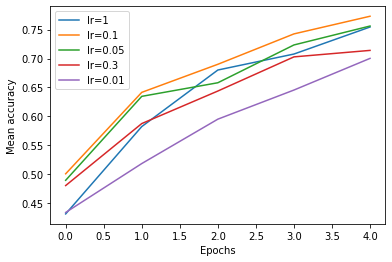

In [8]:
dfs = analysis.trial_dataframes
# [d.mean_accuracy.plot() for d in dfs.values()]
ax = None
for d in dfs.values():
  ax = d.mean_accuracy.plot(ax=ax, label='asd')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean accuracy')
ax.legend(['lr=0.1', 'lr=0.05', 'lr=0.75', 'lr=0.125', 'lr=0.15'])

Momentum


In [9]:
# Config for ResNet hyperparameter sensitivity analysis
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.9, 0.5, 0.7, 0.8, 0.99]),
    "weight_decay": tune.grid_search([0.0001]),
    "k": tune.grid_search([12]),
    "blocks": tune.grid_search([[6,12,24,16]])
}

print(config["k"])

#train_cifar(config)

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.CIFAR10("~/data", train=True, download=True)

analysis2 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

{'grid_search': [12]}
Files already downloaded and verified


2022-04-21 00:57:30,702	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-21 00:57:30,835	INFO trial_runner.py:803 -- starting train_cifar_0576d_00000


(train_cifar pid=5630) Files already downloaded and verified
(train_cifar pid=5630) Files already downloaded and verified
(train_cifar pid=5630) Files already downloaded and verified


(train_cifar pid=5630) Finished Training epoch 0


Result for train_cifar_0576d_00000:
  date: 2022-04-21_00-59-12
  done: false
  experiment_id: 198f6b88e2a6480fa4a24aa41b35ee69
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4616
  node_ip: 172.28.0.2
  pid: 5630
  time_since_restore: 98.83742189407349
  time_this_iter_s: 98.83742189407349
  time_total_s: 98.83742189407349
  timestamp: 1650502752
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0576d_00000
  warmup_time: 0.004315376281738281
  
(train_cifar pid=5630) epoch 1 test_loss 234.05634784698486 test_steps 157 test_acc 0.4616


(train_cifar pid=5630) Finished Training epoch 1


Result for train_cifar_0576d_00000:
  date: 2022-04-21_01-00-43
  done: false
  experiment_id: 198f6b88e2a6480fa4a24aa41b35ee69
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5795
  node_ip: 172.28.0.2
  pid: 5630
  time_since_restore: 190.71595358848572
  time_this_iter_s: 91.87853169441223
  time_total_s: 190.71595358848572
  timestamp: 1650502843
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0576d_00000
  warmup_time: 0.004315376281738281
  
(train_cifar pid=5630) epoch 1 test_loss 189.85476458072662 test_steps 157 test_acc 0.5795


(train_cifar pid=5630) Finished Training epoch 2


Result for train_cifar_0576d_00000:
  date: 2022-04-21_01-02-16
  done: false
  experiment_id: 198f6b88e2a6480fa4a24aa41b35ee69
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6279
  node_ip: 172.28.0.2
  pid: 5630
  time_since_restore: 282.8622169494629
  time_this_iter_s: 92.14626336097717
  time_total_s: 282.8622169494629
  timestamp: 1650502936
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0576d_00000
  warmup_time: 0.004315376281738281
  
(train_cifar pid=5630) epoch 1 test_loss 164.78803670406342 test_steps 157 test_acc 0.6279


(train_cifar pid=5630) Finished Training epoch 3


Result for train_cifar_0576d_00000:
  date: 2022-04-21_01-03-48
  done: false
  experiment_id: 198f6b88e2a6480fa4a24aa41b35ee69
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.6975
  node_ip: 172.28.0.2
  pid: 5630
  time_since_restore: 374.9151613712311
  time_this_iter_s: 92.05294442176819
  time_total_s: 374.9151613712311
  timestamp: 1650503028
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0576d_00000
  warmup_time: 0.004315376281738281
  
(train_cifar pid=5630) epoch 1 test_loss 135.2349173426628 test_steps 157 test_acc 0.6975


(train_cifar pid=5630) Finished Training epoch 4


Result for train_cifar_0576d_00000:
  date: 2022-04-21_01-05-20
  done: false
  experiment_id: 198f6b88e2a6480fa4a24aa41b35ee69
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7189
  node_ip: 172.28.0.2
  pid: 5630
  time_since_restore: 466.8524408340454
  time_this_iter_s: 91.93727946281433
  time_total_s: 466.8524408340454
  timestamp: 1650503120
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0576d_00000
  warmup_time: 0.004315376281738281
  
Result for train_cifar_0576d_00000:
  date: 2022-04-21_01-05-20
  done: true
  experiment_id: 198f6b88e2a6480fa4a24aa41b35ee69
  experiment_tag: 0_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7189
  node_ip: 172.28.0.2
  pid: 5630
  time_since_restore: 466.8524408340454
  time_this_iter_s: 91.93727946281433
  time_total_s: 466.8524408340454
  timestamp: 1650503120
  timesteps_since_restore: 0
  training_ite

2022-04-21 01:05:20,522	INFO trial_runner.py:803 -- starting train_cifar_0576d_00001


(train_cifar pid=5805) Files already downloaded and verified
(train_cifar pid=5805) Files already downloaded and verified
(train_cifar pid=5805) Files already downloaded and verified


(train_cifar pid=5805) Finished Training epoch 0


Result for train_cifar_0576d_00001:
  date: 2022-04-21_01-07-02
  done: false
  experiment_id: 17293af40be443b68551bf35dde9d523
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.5295
  node_ip: 172.28.0.2
  pid: 5805
  time_since_restore: 99.37044405937195
  time_this_iter_s: 99.37044405937195
  time_total_s: 99.37044405937195
  timestamp: 1650503222
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0576d_00001
  warmup_time: 0.003149271011352539
  
(train_cifar pid=5805) epoch 1 test_loss 212.69408011436462 test_steps 157 test_acc 0.5295


(train_cifar pid=5805) Finished Training epoch 1


Result for train_cifar_0576d_00001:
  date: 2022-04-21_01-08-34
  done: false
  experiment_id: 17293af40be443b68551bf35dde9d523
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6276
  node_ip: 172.28.0.2
  pid: 5805
  time_since_restore: 191.40919184684753
  time_this_iter_s: 92.03874778747559
  time_total_s: 191.40919184684753
  timestamp: 1650503314
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0576d_00001
  warmup_time: 0.003149271011352539
  
(train_cifar pid=5805) epoch 1 test_loss 170.687624335289 test_steps 157 test_acc 0.6276


(train_cifar pid=5805) Finished Training epoch 2


Result for train_cifar_0576d_00001:
  date: 2022-04-21_01-10-05
  done: false
  experiment_id: 17293af40be443b68551bf35dde9d523
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6537
  node_ip: 172.28.0.2
  pid: 5805
  time_since_restore: 283.143027305603
  time_this_iter_s: 91.7338354587555
  time_total_s: 283.143027305603
  timestamp: 1650503405
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0576d_00001
  warmup_time: 0.003149271011352539
  
(train_cifar pid=5805) epoch 1 test_loss 157.14112597703934 test_steps 157 test_acc 0.6537


(train_cifar pid=5805) Finished Training epoch 3


Result for train_cifar_0576d_00001:
  date: 2022-04-21_01-11-37
  done: false
  experiment_id: 17293af40be443b68551bf35dde9d523
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7487
  node_ip: 172.28.0.2
  pid: 5805
  time_since_restore: 375.12161135673523
  time_this_iter_s: 91.9785840511322
  time_total_s: 375.12161135673523
  timestamp: 1650503497
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0576d_00001
  warmup_time: 0.003149271011352539
  
(train_cifar pid=5805) epoch 1 test_loss 113.71513122320175 test_steps 157 test_acc 0.7487


(train_cifar pid=5805) Finished Training epoch 4


Result for train_cifar_0576d_00001:
  date: 2022-04-21_01-13-09
  done: false
  experiment_id: 17293af40be443b68551bf35dde9d523
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7665
  node_ip: 172.28.0.2
  pid: 5805
  time_since_restore: 466.9319496154785
  time_this_iter_s: 91.81033825874329
  time_total_s: 466.9319496154785
  timestamp: 1650503589
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0576d_00001
  warmup_time: 0.003149271011352539
  
Result for train_cifar_0576d_00001:
  date: 2022-04-21_01-13-09
  done: true
  experiment_id: 17293af40be443b68551bf35dde9d523
  experiment_tag: 1_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.5,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7665
  node_ip: 172.28.0.2
  pid: 5805
  time_since_restore: 466.9319496154785
  time_this_iter_s: 91.81033825874329
  time_total_s: 466.9319496154785
  timestamp: 1650503589
  timesteps_since_restore: 0
  training_ite

2022-04-21 01:13:10,583	INFO trial_runner.py:803 -- starting train_cifar_0576d_00002


(train_cifar pid=5953) Files already downloaded and verified
(train_cifar pid=5953) Files already downloaded and verified
(train_cifar pid=5953) Files already downloaded and verified


(train_cifar pid=5953) Finished Training epoch 0


Result for train_cifar_0576d_00002:
  date: 2022-04-21_01-14-52
  done: false
  experiment_id: ec893afcc067487e98d6727e13631401
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4919
  node_ip: 172.28.0.2
  pid: 5953
  time_since_restore: 99.36765575408936
  time_this_iter_s: 99.36765575408936
  time_total_s: 99.36765575408936
  timestamp: 1650503692
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0576d_00002
  warmup_time: 0.0031287670135498047
  
(train_cifar pid=5953) epoch 1 test_loss 227.95637345314026 test_steps 157 test_acc 0.4919


(train_cifar pid=5953) Finished Training epoch 1


Result for train_cifar_0576d_00002:
  date: 2022-04-21_01-16-24
  done: false
  experiment_id: ec893afcc067487e98d6727e13631401
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6646
  node_ip: 172.28.0.2
  pid: 5953
  time_since_restore: 191.92435097694397
  time_this_iter_s: 92.55669522285461
  time_total_s: 191.92435097694397
  timestamp: 1650503784
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0576d_00002
  warmup_time: 0.0031287670135498047
  
(train_cifar pid=5953) epoch 1 test_loss 151.8583555817604 test_steps 157 test_acc 0.6646


(train_cifar pid=5953) Finished Training epoch 2


Result for train_cifar_0576d_00002:
  date: 2022-04-21_01-17-57
  done: false
  experiment_id: ec893afcc067487e98d6727e13631401
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.748
  node_ip: 172.28.0.2
  pid: 5953
  time_since_restore: 284.6990752220154
  time_this_iter_s: 92.77472424507141
  time_total_s: 284.6990752220154
  timestamp: 1650503877
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0576d_00002
  warmup_time: 0.0031287670135498047
  
(train_cifar pid=5953) epoch 1 test_loss 115.02948886156082 test_steps 157 test_acc 0.748


(train_cifar pid=5953) Finished Training epoch 3


Result for train_cifar_0576d_00002:
  date: 2022-04-21_01-19-30
  done: false
  experiment_id: ec893afcc067487e98d6727e13631401
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7642
  node_ip: 172.28.0.2
  pid: 5953
  time_since_restore: 377.69378662109375
  time_this_iter_s: 92.99471139907837
  time_total_s: 377.69378662109375
  timestamp: 1650503970
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0576d_00002
  warmup_time: 0.0031287670135498047
  
(train_cifar pid=5953) epoch 1 test_loss 108.16689646244049 test_steps 157 test_acc 0.7642


(train_cifar pid=5953) Finished Training epoch 4


2022-04-21 01:21:02,634	INFO trial_runner.py:803 -- starting train_cifar_0576d_00003


Result for train_cifar_0576d_00002:
  date: 2022-04-21_01-21-02
  done: false
  experiment_id: ec893afcc067487e98d6727e13631401
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7879
  node_ip: 172.28.0.2
  pid: 5953
  time_since_restore: 469.570387840271
  time_this_iter_s: 91.87660121917725
  time_total_s: 469.570387840271
  timestamp: 1650504062
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0576d_00002
  warmup_time: 0.0031287670135498047
  
Result for train_cifar_0576d_00002:
  date: 2022-04-21_01-21-02
  done: true
  experiment_id: ec893afcc067487e98d6727e13631401
  experiment_tag: 2_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.7,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7879
  node_ip: 172.28.0.2
  pid: 5953
  time_since_restore: 469.570387840271
  time_this_iter_s: 91.87660121917725
  time_total_s: 469.570387840271
  timestamp: 1650504062
  timesteps_since_restore: 0
  training_iterat

(train_cifar pid=6110) Finished Training epoch 0


Result for train_cifar_0576d_00003:
  date: 2022-04-21_01-22-43
  done: false
  experiment_id: 0d4ab8d8e7e4458ca2bd98f62eed07b0
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.5055
  node_ip: 172.28.0.2
  pid: 6110
  time_since_restore: 98.94274377822876
  time_this_iter_s: 98.94274377822876
  time_total_s: 98.94274377822876
  timestamp: 1650504163
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0576d_00003
  warmup_time: 0.003026723861694336
  
(train_cifar pid=6110) epoch 1 test_loss 219.34451341629028 test_steps 157 test_acc 0.5055


(train_cifar pid=6110) Finished Training epoch 1


Result for train_cifar_0576d_00003:
  date: 2022-04-21_01-24-16
  done: false
  experiment_id: 0d4ab8d8e7e4458ca2bd98f62eed07b0
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6091
  node_ip: 172.28.0.2
  pid: 6110
  time_since_restore: 192.00429677963257
  time_this_iter_s: 93.06155300140381
  time_total_s: 192.00429677963257
  timestamp: 1650504256
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0576d_00003
  warmup_time: 0.003026723861694336
  
(train_cifar pid=6110) epoch 1 test_loss 178.17770677804947 test_steps 157 test_acc 0.6091


(train_cifar pid=6110) Finished Training epoch 2


Result for train_cifar_0576d_00003:
  date: 2022-04-21_01-25-48
  done: false
  experiment_id: 0d4ab8d8e7e4458ca2bd98f62eed07b0
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6812
  node_ip: 172.28.0.2
  pid: 6110
  time_since_restore: 284.1299695968628
  time_this_iter_s: 92.12567281723022
  time_total_s: 284.1299695968628
  timestamp: 1650504348
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0576d_00003
  warmup_time: 0.003026723861694336
  
(train_cifar pid=6110) epoch 1 test_loss 148.126587331295 test_steps 157 test_acc 0.6812


(train_cifar pid=6110) Finished Training epoch 3


Result for train_cifar_0576d_00003:
  date: 2022-04-21_01-27-21
  done: false
  experiment_id: 0d4ab8d8e7e4458ca2bd98f62eed07b0
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7322
  node_ip: 172.28.0.2
  pid: 6110
  time_since_restore: 376.492436170578
  time_this_iter_s: 92.36246657371521
  time_total_s: 376.492436170578
  timestamp: 1650504441
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0576d_00003
  warmup_time: 0.003026723861694336
  
(train_cifar pid=6110) epoch 1 test_loss 123.60668390989304 test_steps 157 test_acc 0.7322


(train_cifar pid=6110) Finished Training epoch 4


2022-04-21 01:28:53,685	INFO trial_runner.py:803 -- starting train_cifar_0576d_00004


Result for train_cifar_0576d_00003:
  date: 2022-04-21_01-28-53
  done: false
  experiment_id: 0d4ab8d8e7e4458ca2bd98f62eed07b0
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7563
  node_ip: 172.28.0.2
  pid: 6110
  time_since_restore: 468.76227927207947
  time_this_iter_s: 92.26984310150146
  time_total_s: 468.76227927207947
  timestamp: 1650504533
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0576d_00003
  warmup_time: 0.003026723861694336
  
Result for train_cifar_0576d_00003:
  date: 2022-04-21_01-28-53
  done: true
  experiment_id: 0d4ab8d8e7e4458ca2bd98f62eed07b0
  experiment_tag: 3_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.8,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7563
  node_ip: 172.28.0.2
  pid: 6110
  time_since_restore: 468.76227927207947
  time_this_iter_s: 92.26984310150146
  time_total_s: 468.76227927207947
  timestamp: 1650504533
  timesteps_since_restore: 0
  training

(train_cifar pid=6315) Finished Training epoch 0


Result for train_cifar_0576d_00004:
  date: 2022-04-21_01-30-34
  done: false
  experiment_id: 8e553d4fd80745a49083a6e163f2c61d
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.2878
  node_ip: 172.28.0.2
  pid: 6315
  time_since_restore: 98.0195300579071
  time_this_iter_s: 98.0195300579071
  time_total_s: 98.0195300579071
  timestamp: 1650504634
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0576d_00004
  warmup_time: 0.003099203109741211
  


(train_cifar pid=6315) epoch 1 test_loss 303.60154843330383 test_steps 157 test_acc 0.2878


(train_cifar pid=6315) Finished Training epoch 1


Result for train_cifar_0576d_00004:
  date: 2022-04-21_01-32-06
  done: false
  experiment_id: 8e553d4fd80745a49083a6e163f2c61d
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.3949
  node_ip: 172.28.0.2
  pid: 6315
  time_since_restore: 190.2781536579132
  time_this_iter_s: 92.2586236000061
  time_total_s: 190.2781536579132
  timestamp: 1650504726
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0576d_00004
  warmup_time: 0.003099203109741211
  
(train_cifar pid=6315) epoch 1 test_loss 258.8811309337616 test_steps 157 test_acc 0.3949


(train_cifar pid=6315) Finished Training epoch 2


Result for train_cifar_0576d_00004:
  date: 2022-04-21_01-33-37
  done: false
  experiment_id: 8e553d4fd80745a49083a6e163f2c61d
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.4061
  node_ip: 172.28.0.2
  pid: 6315
  time_since_restore: 281.73163080215454
  time_this_iter_s: 91.45347714424133
  time_total_s: 281.73163080215454
  timestamp: 1650504817
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0576d_00004
  warmup_time: 0.003099203109741211
  
(train_cifar pid=6315) epoch 1 test_loss 253.2703105211258 test_steps 157 test_acc 0.4061


(train_cifar pid=6315) Finished Training epoch 3


Result for train_cifar_0576d_00004:
  date: 2022-04-21_01-35-09
  done: false
  experiment_id: 8e553d4fd80745a49083a6e163f2c61d
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.4724
  node_ip: 172.28.0.2
  pid: 6315
  time_since_restore: 373.43988728523254
  time_this_iter_s: 91.708256483078
  time_total_s: 373.43988728523254
  timestamp: 1650504909
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0576d_00004
  warmup_time: 0.003099203109741211
  
(train_cifar pid=6315) epoch 1 test_loss 226.35249376296997 test_steps 157 test_acc 0.4724


(train_cifar pid=6315) Finished Training epoch 4


Result for train_cifar_0576d_00004:
  date: 2022-04-21_01-36-40
  done: false
  experiment_id: 8e553d4fd80745a49083a6e163f2c61d
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.501
  node_ip: 172.28.0.2
  pid: 6315
  time_since_restore: 464.892808675766
  time_this_iter_s: 91.45292139053345
  time_total_s: 464.892808675766
  timestamp: 1650505000
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0576d_00004
  warmup_time: 0.003099203109741211
  
Result for train_cifar_0576d_00004:
  date: 2022-04-21_01-36-40
  done: true
  experiment_id: 8e553d4fd80745a49083a6e163f2c61d
  experiment_tag: 4_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.99,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.501
  node_ip: 172.28.0.2
  pid: 6315
  time_since_restore: 464.892808675766
  time_this_iter_s: 91.45292139053345
  time_total_s: 464.892808675766
  timestamp: 1650505000
  timesteps_since_restore: 0
  training_iteratio

2022-04-21 01:36:41,044	INFO tune.py:702 -- Total run time: 2350.36 seconds (2350.21 seconds for the tuning loop).


(train_cifar pid=6315) epoch 1 test_loss 226.5311415195465 test_steps 157 test_acc 0.501


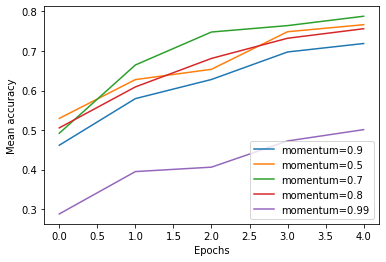

In [14]:
dfs = analysis2.trial_dataframes
# [d.mean_accuracy.plot() for d in dfs.values()]
ax = None
for d in dfs.values():
  ax = d.mean_accuracy.plot(ax=ax, label='asd')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean accuracy')
ax.legend(['momentum=0.9', 'momentum=0.5', 'momentum=0.7', 'momentum=0.8', 'momentum=0.99'])

Weight decay


In [ ]:
# Config for ResNet hyperparameter sensitivity analysis
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001, 0.0005, 0.001, 0.01, 0.1]),
    "k": tune.grid_search([12]),
    "blocks": tune.grid_search([[6,12,24,16]])
}

print(config["k"])

#train_cifar(config)

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.CIFAR10("~/data", train=True, download=True)

analysis3 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

In [ ]:
dfs = analysis3.trial_dataframes
# [d.mean_accuracy.plot() for d in dfs.values()]
ax = None
for d in dfs.values():
  ax = d.mean_accuracy.plot(ax=ax, label='asd')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean accuracy')
ax.legend(['lr=1', 'lr=0.1', 'lr=0.05', 'lr=0.3', 'lr=0.01'])

k

In [11]:
# Config for ResNet hyperparameter sensitivity analysis
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001]),
    "k": tune.grid_search([6, 8, 10, 12, 14]),
    "blocks": tune.grid_search([[6,12,24,16]])
}

print(config["k"])

#train_cifar(config)

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.CIFAR10("~/data", train=True, download=True)

analysis4 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

{'grid_search': [6, 8, 10, 12, 14]}
Files already downloaded and verified


2022-04-21 01:38:23,250	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-21 01:38:23,384	INFO trial_runner.py:803 -- starting train_cifar_bb4bf_00000


(train_cifar pid=6573) Files already downloaded and verified
(train_cifar pid=6573) Files already downloaded and verified
(train_cifar pid=6573) Files already downloaded and verified


(train_cifar pid=6573) Finished Training epoch 0


Result for train_cifar_bb4bf_00000:
  date: 2022-04-21_01-39-48
  done: false
  experiment_id: b958852d53b040a5921e91e9ec9f996f
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4607
  node_ip: 172.28.0.2
  pid: 6573
  time_since_restore: 82.39928770065308
  time_this_iter_s: 82.39928770065308
  time_total_s: 82.39928770065308
  timestamp: 1650505188
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb4bf_00000
  warmup_time: 0.006031990051269531
  
(train_cifar pid=6573) epoch 1 test_loss 230.04137182235718 test_steps 157 test_acc 0.4607


(train_cifar pid=6573) Finished Training epoch 1


Result for train_cifar_bb4bf_00000:
  date: 2022-04-21_01-41-04
  done: false
  experiment_id: b958852d53b040a5921e91e9ec9f996f
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6247
  node_ip: 172.28.0.2
  pid: 6573
  time_since_restore: 158.6654314994812
  time_this_iter_s: 76.26614379882812
  time_total_s: 158.6654314994812
  timestamp: 1650505264
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: bb4bf_00000
  warmup_time: 0.006031990051269531
  
(train_cifar pid=6573) epoch 1 test_loss 168.6350291967392 test_steps 157 test_acc 0.6247


(train_cifar pid=6573) Finished Training epoch 2


Result for train_cifar_bb4bf_00000:
  date: 2022-04-21_01-42-20
  done: false
  experiment_id: b958852d53b040a5921e91e9ec9f996f
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6721
  node_ip: 172.28.0.2
  pid: 6573
  time_since_restore: 234.60919761657715
  time_this_iter_s: 75.94376611709595
  time_total_s: 234.60919761657715
  timestamp: 1650505340
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: bb4bf_00000
  warmup_time: 0.006031990051269531
  
(train_cifar pid=6573) epoch 1 test_loss 148.53317940235138 test_steps 157 test_acc 0.6721


(train_cifar pid=6573) Finished Training epoch 3


Result for train_cifar_bb4bf_00000:
  date: 2022-04-21_01-43-36
  done: false
  experiment_id: b958852d53b040a5921e91e9ec9f996f
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.6963
  node_ip: 172.28.0.2
  pid: 6573
  time_since_restore: 310.6093518733978
  time_this_iter_s: 76.00015425682068
  time_total_s: 310.6093518733978
  timestamp: 1650505416
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: bb4bf_00000
  warmup_time: 0.006031990051269531
  
(train_cifar pid=6573) epoch 1 test_loss 135.56244561076164 test_steps 157 test_acc 0.6963


(train_cifar pid=6573) Finished Training epoch 4


Result for train_cifar_bb4bf_00000:
  date: 2022-04-21_01-44-52
  done: false
  experiment_id: b958852d53b040a5921e91e9ec9f996f
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7143
  node_ip: 172.28.0.2
  pid: 6573
  time_since_restore: 386.83322262763977
  time_this_iter_s: 76.22387075424194
  time_total_s: 386.83322262763977
  timestamp: 1650505492
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: bb4bf_00000
  warmup_time: 0.006031990051269531
  
Result for train_cifar_bb4bf_00000:
  date: 2022-04-21_01-44-52
  done: true
  experiment_id: b958852d53b040a5921e91e9ec9f996f
  experiment_tag: 0_blocks=[6, 12, 24, 16],k=6,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7143
  node_ip: 172.28.0.2
  pid: 6573
  time_since_restore: 386.83322262763977
  time_this_iter_s: 76.22387075424194
  time_total_s: 386.83322262763977
  timestamp: 1650505492
  timesteps_since_restore: 0
  training_

2022-04-21 01:44:52,776	INFO trial_runner.py:803 -- starting train_cifar_bb4bf_00001


(train_cifar pid=6702) Files already downloaded and verified
(train_cifar pid=6702) Files already downloaded and verified
(train_cifar pid=6702) Files already downloaded and verified


(train_cifar pid=6702) Finished Training epoch 0


Result for train_cifar_bb4bf_00001:
  date: 2022-04-21_01-46-19
  done: false
  experiment_id: 59db654e6cd5461f939064b2675afa24
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4306
  node_ip: 172.28.0.2
  pid: 6702
  time_since_restore: 84.53961968421936
  time_this_iter_s: 84.53961968421936
  time_total_s: 84.53961968421936
  timestamp: 1650505579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb4bf_00001
  warmup_time: 0.0037016868591308594
  
(train_cifar pid=6702) epoch 1 test_loss 250.0042976140976 test_steps 157 test_acc 0.4306


(train_cifar pid=6702) Finished Training epoch 1


Result for train_cifar_bb4bf_00001:
  date: 2022-04-21_01-47-37
  done: false
  experiment_id: 59db654e6cd5461f939064b2675afa24
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5964
  node_ip: 172.28.0.2
  pid: 6702
  time_since_restore: 162.73486590385437
  time_this_iter_s: 78.19524621963501
  time_total_s: 162.73486590385437
  timestamp: 1650505657
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: bb4bf_00001
  warmup_time: 0.0037016868591308594
  
(train_cifar pid=6702) epoch 1 test_loss 178.34487384557724 test_steps 157 test_acc 0.5964


(train_cifar pid=6702) Finished Training epoch 2


Result for train_cifar_bb4bf_00001:
  date: 2022-04-21_01-48-56
  done: false
  experiment_id: 59db654e6cd5461f939064b2675afa24
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6548
  node_ip: 172.28.0.2
  pid: 6702
  time_since_restore: 241.01530241966248
  time_this_iter_s: 78.2804365158081
  time_total_s: 241.01530241966248
  timestamp: 1650505736
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: bb4bf_00001
  warmup_time: 0.0037016868591308594
  
(train_cifar pid=6702) epoch 1 test_loss 156.0143404006958 test_steps 157 test_acc 0.6548


(train_cifar pid=6702) Finished Training epoch 3


Result for train_cifar_bb4bf_00001:
  date: 2022-04-21_01-50-14
  done: false
  experiment_id: 59db654e6cd5461f939064b2675afa24
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7194
  node_ip: 172.28.0.2
  pid: 6702
  time_since_restore: 319.15211296081543
  time_this_iter_s: 78.13681054115295
  time_total_s: 319.15211296081543
  timestamp: 1650505814
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: bb4bf_00001
  warmup_time: 0.0037016868591308594
  
(train_cifar pid=6702) epoch 1 test_loss 127.94915014505386 test_steps 157 test_acc 0.7194


(train_cifar pid=6702) Finished Training epoch 4


Result for train_cifar_bb4bf_00001:
  date: 2022-04-21_01-51-32
  done: false
  experiment_id: 59db654e6cd5461f939064b2675afa24
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7329
  node_ip: 172.28.0.2
  pid: 6702
  time_since_restore: 397.5318386554718
  time_this_iter_s: 78.37972569465637
  time_total_s: 397.5318386554718
  timestamp: 1650505892
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: bb4bf_00001
  warmup_time: 0.0037016868591308594
  
Result for train_cifar_bb4bf_00001:
  date: 2022-04-21_01-51-32
  done: true
  experiment_id: 59db654e6cd5461f939064b2675afa24
  experiment_tag: 1_blocks=[6, 12, 24, 16],k=8,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7329
  node_ip: 172.28.0.2
  pid: 6702
  time_since_restore: 397.5318386554718
  time_this_iter_s: 78.37972569465637
  time_total_s: 397.5318386554718
  timestamp: 1650505892
  timesteps_since_restore: 0
  training_ite

2022-04-21 01:51:32,820	INFO trial_runner.py:803 -- starting train_cifar_bb4bf_00002


(train_cifar pid=6834) Files already downloaded and verified
(train_cifar pid=6834) Files already downloaded and verified
(train_cifar pid=6834) Files already downloaded and verified


(train_cifar pid=6834) Finished Training epoch 0


Result for train_cifar_bb4bf_00002:
  date: 2022-04-21_01-53-07
  done: false
  experiment_id: 702646aa71dc44c18a6acdd68cd7043c
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4653
  node_ip: 172.28.0.2
  pid: 6834
  time_since_restore: 92.74528789520264
  time_this_iter_s: 92.74528789520264
  time_total_s: 92.74528789520264
  timestamp: 1650505987
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb4bf_00002
  warmup_time: 0.003337383270263672
  
(train_cifar pid=6834) epoch 1 test_loss 231.0066270828247 test_steps 157 test_acc 0.4653


(train_cifar pid=6834) Finished Training epoch 1


Result for train_cifar_bb4bf_00002:
  date: 2022-04-21_01-54-34
  done: false
  experiment_id: 702646aa71dc44c18a6acdd68cd7043c
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5723
  node_ip: 172.28.0.2
  pid: 6834
  time_since_restore: 179.15792179107666
  time_this_iter_s: 86.41263389587402
  time_total_s: 179.15792179107666
  timestamp: 1650506074
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: bb4bf_00002
  warmup_time: 0.003337383270263672
  
(train_cifar pid=6834) epoch 1 test_loss 191.74929755926132 test_steps 157 test_acc 0.5723


(train_cifar pid=6834) Finished Training epoch 2


Result for train_cifar_bb4bf_00002:
  date: 2022-04-21_01-56-00
  done: false
  experiment_id: 702646aa71dc44c18a6acdd68cd7043c
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6589
  node_ip: 172.28.0.2
  pid: 6834
  time_since_restore: 265.14819383621216
  time_this_iter_s: 85.9902720451355
  time_total_s: 265.14819383621216
  timestamp: 1650506160
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: bb4bf_00002
  warmup_time: 0.003337383270263672
  
(train_cifar pid=6834) epoch 1 test_loss 154.30285489559174 test_steps 157 test_acc 0.6589


(train_cifar pid=6834) Finished Training epoch 3


Result for train_cifar_bb4bf_00002:
  date: 2022-04-21_01-57-26
  done: false
  experiment_id: 702646aa71dc44c18a6acdd68cd7043c
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7024
  node_ip: 172.28.0.2
  pid: 6834
  time_since_restore: 351.33984112739563
  time_this_iter_s: 86.19164729118347
  time_total_s: 351.33984112739563
  timestamp: 1650506246
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: bb4bf_00002
  warmup_time: 0.003337383270263672
  
(train_cifar pid=6834) epoch 1 test_loss 135.27581483125687 test_steps 157 test_acc 0.7024


(train_cifar pid=6834) Finished Training epoch 4


Result for train_cifar_bb4bf_00002:
  date: 2022-04-21_01-58-52
  done: false
  experiment_id: 702646aa71dc44c18a6acdd68cd7043c
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7043
  node_ip: 172.28.0.2
  pid: 6834
  time_since_restore: 437.08378744125366
  time_this_iter_s: 85.74394631385803
  time_total_s: 437.08378744125366
  timestamp: 1650506332
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: bb4bf_00002
  warmup_time: 0.003337383270263672
  
Result for train_cifar_bb4bf_00002:
  date: 2022-04-21_01-58-52
  done: true
  experiment_id: 702646aa71dc44c18a6acdd68cd7043c
  experiment_tag: 2_blocks=[6, 12, 24, 16],k=10,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7043
  node_ip: 172.28.0.2
  pid: 6834
  time_since_restore: 437.08378744125366
  time_this_iter_s: 85.74394631385803
  time_total_s: 437.08378744125366
  timestamp: 1650506332
  timesteps_since_restore: 0
  training

2022-04-21 01:58:52,877	INFO trial_runner.py:803 -- starting train_cifar_bb4bf_00003


(train_cifar pid=6991) Files already downloaded and verified
(train_cifar pid=6991) Files already downloaded and verified
(train_cifar pid=6991) Files already downloaded and verified


(train_cifar pid=6991) Finished Training epoch 0


Result for train_cifar_bb4bf_00003:
  date: 2022-04-21_02-00-32
  done: false
  experiment_id: e206f131eb1b44f0b86ada8b061d2bbe
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4823
  node_ip: 172.28.0.2
  pid: 6991
  time_since_restore: 97.87838554382324
  time_this_iter_s: 97.87838554382324
  time_total_s: 97.87838554382324
  timestamp: 1650506432
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb4bf_00003
  warmup_time: 0.0031392574310302734
  
(train_cifar pid=6991) epoch 1 test_loss 227.84847748279572 test_steps 157 test_acc 0.4823


(train_cifar pid=6991) Finished Training epoch 1


Result for train_cifar_bb4bf_00003:
  date: 2022-04-21_02-02-04
  done: false
  experiment_id: e206f131eb1b44f0b86ada8b061d2bbe
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6018
  node_ip: 172.28.0.2
  pid: 6991
  time_since_restore: 189.2950325012207
  time_this_iter_s: 91.41664695739746
  time_total_s: 189.2950325012207
  timestamp: 1650506524
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: bb4bf_00003
  warmup_time: 0.0031392574310302734
  
(train_cifar pid=6991) epoch 1 test_loss 180.53176122903824 test_steps 157 test_acc 0.6018


(train_cifar pid=6991) Finished Training epoch 2


Result for train_cifar_bb4bf_00003:
  date: 2022-04-21_02-03-36
  done: false
  experiment_id: e206f131eb1b44f0b86ada8b061d2bbe
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6421
  node_ip: 172.28.0.2
  pid: 6991
  time_since_restore: 281.2316188812256
  time_this_iter_s: 91.93658638000488
  time_total_s: 281.2316188812256
  timestamp: 1650506616
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: bb4bf_00003
  warmup_time: 0.0031392574310302734
  
(train_cifar pid=6991) epoch 1 test_loss 160.92251479625702 test_steps 157 test_acc 0.6421


(train_cifar pid=6991) Finished Training epoch 3


Result for train_cifar_bb4bf_00003:
  date: 2022-04-21_02-05-09
  done: false
  experiment_id: e206f131eb1b44f0b86ada8b061d2bbe
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7228
  node_ip: 172.28.0.2
  pid: 6991
  time_since_restore: 374.4982485771179
  time_this_iter_s: 93.26662969589233
  time_total_s: 374.4982485771179
  timestamp: 1650506709
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: bb4bf_00003
  warmup_time: 0.0031392574310302734
  
(train_cifar pid=6991) epoch 1 test_loss 125.19307625293732 test_steps 157 test_acc 0.7228


(train_cifar pid=6991) Finished Training epoch 4


Result for train_cifar_bb4bf_00003:
  date: 2022-04-21_02-06-41
  done: false
  experiment_id: e206f131eb1b44f0b86ada8b061d2bbe
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.738
  node_ip: 172.28.0.2
  pid: 6991
  time_since_restore: 466.564400434494
  time_this_iter_s: 92.0661518573761
  time_total_s: 466.564400434494
  timestamp: 1650506801
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: bb4bf_00003
  warmup_time: 0.0031392574310302734
  
Result for train_cifar_bb4bf_00003:
  date: 2022-04-21_02-06-41
  done: true
  experiment_id: e206f131eb1b44f0b86ada8b061d2bbe
  experiment_tag: 3_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.738
  node_ip: 172.28.0.2
  pid: 6991
  time_since_restore: 466.564400434494
  time_this_iter_s: 92.0661518573761
  time_total_s: 466.564400434494
  timestamp: 1650506801
  timesteps_since_restore: 0
  training_iteration:

2022-04-21 02:06:41,935	INFO trial_runner.py:803 -- starting train_cifar_bb4bf_00004


(train_cifar pid=7141) Files already downloaded and verified
(train_cifar pid=7141) Files already downloaded and verified
(train_cifar pid=7141) Files already downloaded and verified


(train_cifar pid=7141) Finished Training epoch 0


Result for train_cifar_bb4bf_00004:
  date: 2022-04-21_02-08-26
  done: false
  experiment_id: 29192f50dc254ad1b655c69d2345bf8a
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4979
  node_ip: 172.28.0.2
  pid: 7141
  time_since_restore: 102.63113760948181
  time_this_iter_s: 102.63113760948181
  time_total_s: 102.63113760948181
  timestamp: 1650506906
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb4bf_00004
  warmup_time: 0.0030896663665771484
  
(train_cifar pid=7141) epoch 1 test_loss 222.65824615955353 test_steps 157 test_acc 0.4979


(train_cifar pid=7141) Finished Training epoch 1


Result for train_cifar_bb4bf_00004:
  date: 2022-04-21_02-10-02
  done: false
  experiment_id: 29192f50dc254ad1b655c69d2345bf8a
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6107
  node_ip: 172.28.0.2
  pid: 7141
  time_since_restore: 198.8350293636322
  time_this_iter_s: 96.20389175415039
  time_total_s: 198.8350293636322
  timestamp: 1650507002
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: bb4bf_00004
  warmup_time: 0.0030896663665771484
  
(train_cifar pid=7141) epoch 1 test_loss 175.55703353881836 test_steps 157 test_acc 0.6107


(train_cifar pid=7141) Finished Training epoch 2


Result for train_cifar_bb4bf_00004:
  date: 2022-04-21_02-11-39
  done: false
  experiment_id: 29192f50dc254ad1b655c69d2345bf8a
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6942
  node_ip: 172.28.0.2
  pid: 7141
  time_since_restore: 294.9628872871399
  time_this_iter_s: 96.12785792350769
  time_total_s: 294.9628872871399
  timestamp: 1650507099
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: bb4bf_00004
  warmup_time: 0.0030896663665771484
  
(train_cifar pid=7141) epoch 1 test_loss 136.8095644712448 test_steps 157 test_acc 0.6942


(train_cifar pid=7141) Finished Training epoch 3


Result for train_cifar_bb4bf_00004:
  date: 2022-04-21_02-13-14
  done: false
  experiment_id: 29192f50dc254ad1b655c69d2345bf8a
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7482
  node_ip: 172.28.0.2
  pid: 7141
  time_since_restore: 390.7877907752991
  time_this_iter_s: 95.82490348815918
  time_total_s: 390.7877907752991
  timestamp: 1650507194
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: bb4bf_00004
  warmup_time: 0.0030896663665771484
  
(train_cifar pid=7141) epoch 1 test_loss 113.68344435095787 test_steps 157 test_acc 0.7482


(train_cifar pid=7141) Finished Training epoch 4


Result for train_cifar_bb4bf_00004:
  date: 2022-04-21_02-14-51
  done: false
  experiment_id: 29192f50dc254ad1b655c69d2345bf8a
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7487
  node_ip: 172.28.0.2
  pid: 7141
  time_since_restore: 486.92115116119385
  time_this_iter_s: 96.13336038589478
  time_total_s: 486.92115116119385
  timestamp: 1650507291
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: bb4bf_00004
  warmup_time: 0.0030896663665771484
  
(train_cifar pid=7141) epoch 1 test_loss 115.96180772781372 test_steps 157 test_acc 0.7487
Result for train_cifar_bb4bf_00004:
  date: 2022-04-21_02-14-51
  done: true
  experiment_id: 29192f50dc254ad1b655c69d2345bf8a
  experiment_tag: 4_blocks=[6, 12, 24, 16],k=14,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7487
  node_ip: 172.28.0.2
  pid: 7141
  time_since_restore: 486.92115116119385
  time_this_iter_s: 96.13336038589478
  time

2022-04-21 02:14:51,205	INFO tune.py:702 -- Total run time: 2187.97 seconds (2187.81 seconds for the tuning loop).


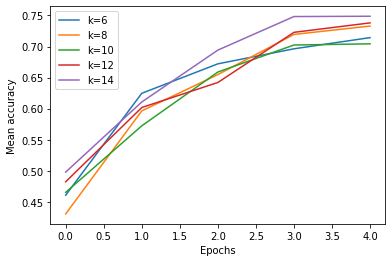

In [15]:
dfs = analysis4.trial_dataframes
# [d.mean_accuracy.plot() for d in dfs.values()]
ax = None
for d in dfs.values():
  ax = d.mean_accuracy.plot(ax=ax, label='asd')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean accuracy')
ax.legend(['k=6', 'k=8', 'k=10', 'k=12', 'k=14'])

blocks


In [16]:
# Config for ResNet hyperparameter sensitivity analysis
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001]),
    "k": tune.grid_search([12]),
    "blocks": tune.grid_search([[6,12,24,16], [6,6,6,6], [6,12,36,24], [6,12,6,12], [6,12,48,32]])
}

print(config["k"])

#train_cifar(config)

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.CIFAR10("~/data", train=True, download=True)

analysis5 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

{'grid_search': [12]}
Files already downloaded and verified


2022-04-21 02:30:00,004	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-21 02:30:00,136	INFO trial_runner.py:803 -- starting train_cifar_f11b2_00000


(train_cifar pid=7601) Files already downloaded and verified
(train_cifar pid=7601) Files already downloaded and verified
(train_cifar pid=7601) Files already downloaded and verified


(train_cifar pid=7601) Finished Training epoch 0


Result for train_cifar_f11b2_00000:
  date: 2022-04-21_02-31-41
  done: false
  experiment_id: 9f2c4a645069447599a84ba772eee814
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4966
  node_ip: 172.28.0.2
  pid: 7601
  time_since_restore: 99.03728008270264
  time_this_iter_s: 99.03728008270264
  time_total_s: 99.03728008270264
  timestamp: 1650508301
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f11b2_00000
  warmup_time: 0.006692171096801758
  
(train_cifar pid=7601) epoch 1 test_loss 220.72035956382751 test_steps 157 test_acc 0.4966


(train_cifar pid=7601) Finished Training epoch 1


Result for train_cifar_f11b2_00000:
  date: 2022-04-21_02-33-12
  done: false
  experiment_id: 9f2c4a645069447599a84ba772eee814
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6186
  node_ip: 172.28.0.2
  pid: 7601
  time_since_restore: 190.35599994659424
  time_this_iter_s: 91.3187198638916
  time_total_s: 190.35599994659424
  timestamp: 1650508392
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f11b2_00000
  warmup_time: 0.006692171096801758
  
(train_cifar pid=7601) epoch 1 test_loss 170.62861639261246 test_steps 157 test_acc 0.6186


(train_cifar pid=7601) Finished Training epoch 2


Result for train_cifar_f11b2_00000:
  date: 2022-04-21_02-34-44
  done: false
  experiment_id: 9f2c4a645069447599a84ba772eee814
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6676
  node_ip: 172.28.0.2
  pid: 7601
  time_since_restore: 282.310405254364
  time_this_iter_s: 91.95440530776978
  time_total_s: 282.310405254364
  timestamp: 1650508484
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f11b2_00000
  warmup_time: 0.006692171096801758
  
(train_cifar pid=7601) epoch 1 test_loss 148.50474345684052 test_steps 157 test_acc 0.6676


(train_cifar pid=7601) Finished Training epoch 3


Result for train_cifar_f11b2_00000:
  date: 2022-04-21_02-36-16
  done: false
  experiment_id: 9f2c4a645069447599a84ba772eee814
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7071
  node_ip: 172.28.0.2
  pid: 7601
  time_since_restore: 374.2486402988434
  time_this_iter_s: 91.93823504447937
  time_total_s: 374.2486402988434
  timestamp: 1650508576
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f11b2_00000
  warmup_time: 0.006692171096801758
  
(train_cifar pid=7601) epoch 1 test_loss 133.1608144044876 test_steps 157 test_acc 0.7071


(train_cifar pid=7601) Finished Training epoch 4


Result for train_cifar_f11b2_00000:
  date: 2022-04-21_02-37-48
  done: false
  experiment_id: 9f2c4a645069447599a84ba772eee814
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7516
  node_ip: 172.28.0.2
  pid: 7601
  time_since_restore: 466.307008266449
  time_this_iter_s: 92.05836796760559
  time_total_s: 466.307008266449
  timestamp: 1650508668
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f11b2_00000
  warmup_time: 0.006692171096801758
  
Result for train_cifar_f11b2_00000:
  date: 2022-04-21_02-37-48
  done: true
  experiment_id: 9f2c4a645069447599a84ba772eee814
  experiment_tag: 0_blocks=[6, 12, 24, 16],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7516
  node_ip: 172.28.0.2
  pid: 7601
  time_since_restore: 466.307008266449
  time_this_iter_s: 92.05836796760559
  time_total_s: 466.307008266449
  timestamp: 1650508668
  timesteps_since_restore: 0
  training_iterati

2022-04-21 02:37:49,110	INFO trial_runner.py:803 -- starting train_cifar_f11b2_00001


(train_cifar pid=7752) Files already downloaded and verified
(train_cifar pid=7752) Files already downloaded and verified
(train_cifar pid=7752) Files already downloaded and verified


(train_cifar pid=7752) Finished Training epoch 0
Result for train_cifar_f11b2_00001:
  date: 2022-04-21_02-38-38
  done: false
  experiment_id: 200754efb686490dafbd4a434d3d6438
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4763
  node_ip: 172.28.0.2
  pid: 7752
  time_since_restore: 46.957772731781006
  time_this_iter_s: 46.957772731781006
  time_total_s: 46.957772731781006
  timestamp: 1650508718
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f11b2_00001
  warmup_time: 0.0033063888549804688
  
(train_cifar pid=7752) epoch 1 test_loss 226.2816038131714 test_steps 157 test_acc 0.4763


(train_cifar pid=7752) Finished Training epoch 1


Result for train_cifar_f11b2_00001:
  date: 2022-04-21_02-39-18
  done: false
  experiment_id: 200754efb686490dafbd4a434d3d6438
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5853
  node_ip: 172.28.0.2
  pid: 7752
  time_since_restore: 87.22201561927795
  time_this_iter_s: 40.26424288749695
  time_total_s: 87.22201561927795
  timestamp: 1650508758
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f11b2_00001
  warmup_time: 0.0033063888549804688
  
(train_cifar pid=7752) epoch 1 test_loss 187.99316102266312 test_steps 157 test_acc 0.5853


(train_cifar pid=7752) Finished Training epoch 2


Result for train_cifar_f11b2_00001:
  date: 2022-04-21_02-39-58
  done: false
  experiment_id: 200754efb686490dafbd4a434d3d6438
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6414
  node_ip: 172.28.0.2
  pid: 7752
  time_since_restore: 127.60774612426758
  time_this_iter_s: 40.385730504989624
  time_total_s: 127.60774612426758
  timestamp: 1650508798
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f11b2_00001
  warmup_time: 0.0033063888549804688
  
(train_cifar pid=7752) epoch 1 test_loss 162.05238211154938 test_steps 157 test_acc 0.6414


(train_cifar pid=7752) Finished Training epoch 3


Result for train_cifar_f11b2_00001:
  date: 2022-04-21_02-40-39
  done: false
  experiment_id: 200754efb686490dafbd4a434d3d6438
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.6747
  node_ip: 172.28.0.2
  pid: 7752
  time_since_restore: 168.0917992591858
  time_this_iter_s: 40.48405313491821
  time_total_s: 168.0917992591858
  timestamp: 1650508839
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f11b2_00001
  warmup_time: 0.0033063888549804688
  
(train_cifar pid=7752) epoch 1 test_loss 146.65097433328629 test_steps 157 test_acc 0.6747


(train_cifar pid=7752) Finished Training epoch 4


Result for train_cifar_f11b2_00001:
  date: 2022-04-21_02-41-19
  done: false
  experiment_id: 200754efb686490dafbd4a434d3d6438
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.6952
  node_ip: 172.28.0.2
  pid: 7752
  time_since_restore: 208.54403805732727
  time_this_iter_s: 40.45223879814148
  time_total_s: 208.54403805732727
  timestamp: 1650508879
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f11b2_00001
  warmup_time: 0.0033063888549804688
  
Result for train_cifar_f11b2_00001:
  date: 2022-04-21_02-41-19
  done: true
  experiment_id: 200754efb686490dafbd4a434d3d6438
  experiment_tag: 1_blocks=[6, 6, 6, 6],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.6952
  node_ip: 172.28.0.2
  pid: 7752
  time_since_restore: 208.54403805732727
  time_this_iter_s: 40.45223879814148
  time_total_s: 208.54403805732727
  timestamp: 1650508879
  timesteps_since_restore: 0
  training_i

2022-04-21 02:41:20,135	INFO trial_runner.py:803 -- starting train_cifar_f11b2_00002


(train_cifar pid=7845) Files already downloaded and verified
(train_cifar pid=7845) Files already downloaded and verified
(train_cifar pid=7845) Files already downloaded and verified


(train_cifar pid=7845) Finished Training epoch 0


Result for train_cifar_f11b2_00002:
  date: 2022-04-21_02-43-26
  done: false
  experiment_id: 858fe87c3fa14024b3c62868f28bc0bb
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4265
  node_ip: 172.28.0.2
  pid: 7845
  time_since_restore: 124.5708372592926
  time_this_iter_s: 124.5708372592926
  time_total_s: 124.5708372592926
  timestamp: 1650509006
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f11b2_00002
  warmup_time: 0.003273487091064453
  
(train_cifar pid=7845) epoch 1 test_loss 257.024994969368 test_steps 157 test_acc 0.4265


(train_cifar pid=7845) Finished Training epoch 1


Result for train_cifar_f11b2_00002:
  date: 2022-04-21_02-45-27
  done: false
  experiment_id: 858fe87c3fa14024b3c62868f28bc0bb
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5285
  node_ip: 172.28.0.2
  pid: 7845
  time_since_restore: 245.25942754745483
  time_this_iter_s: 120.68859028816223
  time_total_s: 245.25942754745483
  timestamp: 1650509127
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f11b2_00002
  warmup_time: 0.003273487091064453
  
(train_cifar pid=7845) epoch 1 test_loss 213.9116085767746 test_steps 157 test_acc 0.5285


(train_cifar pid=7845) Finished Training epoch 2


Result for train_cifar_f11b2_00002:
  date: 2022-04-21_02-47-28
  done: false
  experiment_id: 858fe87c3fa14024b3c62868f28bc0bb
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.592
  node_ip: 172.28.0.2
  pid: 7845
  time_since_restore: 366.1596009731293
  time_this_iter_s: 120.90017342567444
  time_total_s: 366.1596009731293
  timestamp: 1650509248
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f11b2_00002
  warmup_time: 0.003273487091064453
  
(train_cifar pid=7845) epoch 1 test_loss 183.807985663414 test_steps 157 test_acc 0.592


(train_cifar pid=7845) Finished Training epoch 3


Result for train_cifar_f11b2_00002:
  date: 2022-04-21_02-49-27
  done: false
  experiment_id: 858fe87c3fa14024b3c62868f28bc0bb
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.6891
  node_ip: 172.28.0.2
  pid: 7845
  time_since_restore: 484.7727448940277
  time_this_iter_s: 118.61314392089844
  time_total_s: 484.7727448940277
  timestamp: 1650509367
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f11b2_00002
  warmup_time: 0.003273487091064453
  
(train_cifar pid=7845) epoch 1 test_loss 139.6044813990593 test_steps 157 test_acc 0.6891


(train_cifar pid=7845) Finished Training epoch 4


Result for train_cifar_f11b2_00002:
  date: 2022-04-21_02-51-25
  done: false
  experiment_id: 858fe87c3fa14024b3c62868f28bc0bb
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.717
  node_ip: 172.28.0.2
  pid: 7845
  time_since_restore: 603.0118033885956
  time_this_iter_s: 118.23905849456787
  time_total_s: 603.0118033885956
  timestamp: 1650509485
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f11b2_00002
  warmup_time: 0.003273487091064453
  
Result for train_cifar_f11b2_00002:
  date: 2022-04-21_02-51-25
  done: true
  experiment_id: 858fe87c3fa14024b3c62868f28bc0bb
  experiment_tag: 2_blocks=[6, 12, 36, 24],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.717
  node_ip: 172.28.0.2
  pid: 7845
  time_since_restore: 603.0118033885956
  time_this_iter_s: 118.23905849456787
  time_total_s: 603.0118033885956
  timestamp: 1650509485
  timesteps_since_restore: 0
  training_ite

2022-04-21 02:51:26,213	INFO trial_runner.py:803 -- starting train_cifar_f11b2_00003


(train_cifar pid=8065) Files already downloaded and verified
(train_cifar pid=8065) Files already downloaded and verified
(train_cifar pid=8065) Files already downloaded and verified


(train_cifar pid=8065) Finished Training epoch 0


Result for train_cifar_f11b2_00003:
  date: 2022-04-21_02-52-33
  done: false
  experiment_id: 4321f2e24de147b79888e9b27aab6558
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.5099
  node_ip: 172.28.0.2
  pid: 8065
  time_since_restore: 64.86674451828003
  time_this_iter_s: 64.86674451828003
  time_total_s: 64.86674451828003
  timestamp: 1650509553
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f11b2_00003
  warmup_time: 0.003316640853881836
  
(train_cifar pid=8065) epoch 1 test_loss 211.63683342933655 test_steps 157 test_acc 0.5099


(train_cifar pid=8065) Finished Training epoch 1


Result for train_cifar_f11b2_00003:
  date: 2022-04-21_02-53-31
  done: false
  experiment_id: 4321f2e24de147b79888e9b27aab6558
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.6115
  node_ip: 172.28.0.2
  pid: 8065
  time_since_restore: 123.10249423980713
  time_this_iter_s: 58.2357497215271
  time_total_s: 123.10249423980713
  timestamp: 1650509611
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f11b2_00003
  warmup_time: 0.003316640853881836
  
(train_cifar pid=8065) epoch 1 test_loss 172.80313324928284 test_steps 157 test_acc 0.6115


(train_cifar pid=8065) Finished Training epoch 2


Result for train_cifar_f11b2_00003:
  date: 2022-04-21_02-54-29
  done: false
  experiment_id: 4321f2e24de147b79888e9b27aab6558
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6914
  node_ip: 172.28.0.2
  pid: 8065
  time_since_restore: 181.16134786605835
  time_this_iter_s: 58.05885362625122
  time_total_s: 181.16134786605835
  timestamp: 1650509669
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f11b2_00003
  warmup_time: 0.003316640853881836
  
(train_cifar pid=8065) epoch 1 test_loss 139.68632173538208 test_steps 157 test_acc 0.6914


(train_cifar pid=8065) Finished Training epoch 3


Result for train_cifar_f11b2_00003:
  date: 2022-04-21_02-55-27
  done: false
  experiment_id: 4321f2e24de147b79888e9b27aab6558
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7064
  node_ip: 172.28.0.2
  pid: 8065
  time_since_restore: 239.1049735546112
  time_this_iter_s: 57.943625688552856
  time_total_s: 239.1049735546112
  timestamp: 1650509727
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f11b2_00003
  warmup_time: 0.003316640853881836
  
(train_cifar pid=8065) epoch 1 test_loss 132.06781655550003 test_steps 157 test_acc 0.7064


(train_cifar pid=8065) Finished Training epoch 4


Result for train_cifar_f11b2_00003:
  date: 2022-04-21_02-56-25
  done: false
  experiment_id: 4321f2e24de147b79888e9b27aab6558
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7383
  node_ip: 172.28.0.2
  pid: 8065
  time_since_restore: 297.2376403808594
  time_this_iter_s: 58.13266682624817
  time_total_s: 297.2376403808594
  timestamp: 1650509785
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f11b2_00003
  warmup_time: 0.003316640853881836
  
Result for train_cifar_f11b2_00003:
  date: 2022-04-21_02-56-25
  done: true
  experiment_id: 4321f2e24de147b79888e9b27aab6558
  experiment_tag: 3_blocks=[6, 12, 6, 12],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7383
  node_ip: 172.28.0.2
  pid: 8065
  time_since_restore: 297.2376403808594
  time_this_iter_s: 58.13266682624817
  time_total_s: 297.2376403808594
  timestamp: 1650509785
  timesteps_since_restore: 0
  training_iter

2022-04-21 02:56:26,244	INFO trial_runner.py:803 -- starting train_cifar_f11b2_00004


(train_cifar pid=8174) Files already downloaded and verified
(train_cifar pid=8174) Files already downloaded and verified
(train_cifar pid=8174) Files already downloaded and verified


(train_cifar pid=8174) Finished Training epoch 0


Result for train_cifar_f11b2_00004:
  date: 2022-04-21_02-59-00
  done: false
  experiment_id: 2217e388cd014a02806432850406a21e
  hostname: d7e2170119a7
  iterations_since_restore: 1
  mean_accuracy: 0.4445
  node_ip: 172.28.0.2
  pid: 8174
  time_since_restore: 152.26177978515625
  time_this_iter_s: 152.26177978515625
  time_total_s: 152.26177978515625
  timestamp: 1650509940
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f11b2_00004
  warmup_time: 0.0034637451171875
  
(train_cifar pid=8174) epoch 1 test_loss 238.90489554405212 test_steps 157 test_acc 0.4445


(train_cifar pid=8174) Finished Training epoch 1


Result for train_cifar_f11b2_00004:
  date: 2022-04-21_03-01-26
  done: false
  experiment_id: 2217e388cd014a02806432850406a21e
  hostname: d7e2170119a7
  iterations_since_restore: 2
  mean_accuracy: 0.5889
  node_ip: 172.28.0.2
  pid: 8174
  time_since_restore: 297.87434124946594
  time_this_iter_s: 145.6125614643097
  time_total_s: 297.87434124946594
  timestamp: 1650510086
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f11b2_00004
  warmup_time: 0.0034637451171875
  
(train_cifar pid=8174) epoch 1 test_loss 182.85441100597382 test_steps 157 test_acc 0.5889


(train_cifar pid=8174) Finished Training epoch 2


Result for train_cifar_f11b2_00004:
  date: 2022-04-21_03-03-52
  done: false
  experiment_id: 2217e388cd014a02806432850406a21e
  hostname: d7e2170119a7
  iterations_since_restore: 3
  mean_accuracy: 0.6418
  node_ip: 172.28.0.2
  pid: 8174
  time_since_restore: 444.28588604927063
  time_this_iter_s: 146.4115447998047
  time_total_s: 444.28588604927063
  timestamp: 1650510232
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f11b2_00004
  warmup_time: 0.0034637451171875
  
(train_cifar pid=8174) epoch 1 test_loss 160.48355841636658 test_steps 157 test_acc 0.6418


(train_cifar pid=8174) Finished Training epoch 3


Result for train_cifar_f11b2_00004:
  date: 2022-04-21_03-06-18
  done: false
  experiment_id: 2217e388cd014a02806432850406a21e
  hostname: d7e2170119a7
  iterations_since_restore: 4
  mean_accuracy: 0.7028
  node_ip: 172.28.0.2
  pid: 8174
  time_since_restore: 590.2088756561279
  time_this_iter_s: 145.9229896068573
  time_total_s: 590.2088756561279
  timestamp: 1650510378
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f11b2_00004
  warmup_time: 0.0034637451171875
  
(train_cifar pid=8174) epoch 1 test_loss 137.03230327367783 test_steps 157 test_acc 0.7028


(train_cifar pid=8174) Finished Training epoch 4


Result for train_cifar_f11b2_00004:
  date: 2022-04-21_03-08-45
  done: false
  experiment_id: 2217e388cd014a02806432850406a21e
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7236
  node_ip: 172.28.0.2
  pid: 8174
  time_since_restore: 736.5914881229401
  time_this_iter_s: 146.38261246681213
  time_total_s: 736.5914881229401
  timestamp: 1650510525
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f11b2_00004
  warmup_time: 0.0034637451171875
  
Result for train_cifar_f11b2_00004:
  date: 2022-04-21_03-08-45
  done: true
  experiment_id: 2217e388cd014a02806432850406a21e
  experiment_tag: 4_blocks=[6, 12, 48, 32],k=12,lr=0.1,momentum=0.9,weight_decay=0.0001
  hostname: d7e2170119a7
  iterations_since_restore: 5
  mean_accuracy: 0.7236
  node_ip: 172.28.0.2
  pid: 8174
  time_since_restore: 736.5914881229401
  time_this_iter_s: 146.38261246681213
  time_total_s: 736.5914881229401
  timestamp: 1650510525
  timesteps_since_restore: 0
  training_ite

2022-04-21 03:08:45,191	INFO tune.py:702 -- Total run time: 2325.20 seconds (2325.06 seconds for the tuning loop).


(train_cifar pid=8174) epoch 1 test_loss 127.40644323825836 test_steps 157 test_acc 0.7236


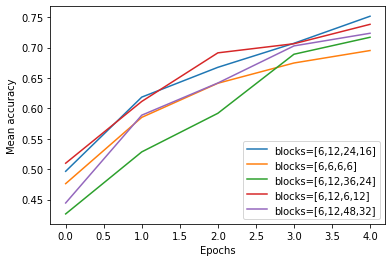

In [17]:
dfs = analysis5.trial_dataframes
# [d.mean_accuracy.plot() for d in dfs.values()]
ax = None
for d in dfs.values():
  ax = d.mean_accuracy.plot(ax=ax, label='asd')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean accuracy')
ax.legend(['blocks=[6,12,24,16]', 'blocks=[6,6,6,6]', 'blocks=[6,12,36,24]', 'blocks=[6,12,6,12]', 'blocks=[6,12,48,32]'])